In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import import_ipynb
from rotation import rotation_matrix, unit_vector, angle_between, x_rotation, y_rotation, z_rotation

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, EditedNearestNeighbours, AllKNN

import csv
from csv import reader
import pickle
from collections import Counter
from matplotlib import pyplot

importing Jupyter notebook from rotation.ipynb


In [2]:
NUM_FEATURES = 3
NUM_JOINTS = 20
NUM_FRAMES = 16
FILE_NAME = '../train.csv'
test_FILE_NAME = '../test.csv'

In [165]:
dtf = pd.read_csv(FILE_NAME, header = None)
#dtf = dtf.set_index(dtf.columns[0])

dtf = dtf.sample(frac = 1)
X = dtf.iloc[:,:-1]
y = dtf.iloc[:,-1]

dtf_test = pd.read_csv(test_FILE_NAME, header = None)
#dtf_test = dtf_test.set_index(dtf_test.columns[0])

dtf_test = dtf_test.sample(frac = 1)
X_test = dtf_test.iloc[:,:]
X_test_index = dtf_test.iloc[:,0]

In [147]:
print(X)

       0         1          2         3        4         5          6    \
3445  3446  2.763200   1.814600   1.24620  4.35440  -5.60340   2.013300   
3940  3941  0.078721   0.236160   0.11386  0.47092  -0.87226   0.070287   
980    981  8.604900  77.222000 -33.38400  1.64850  80.84900 -28.205000   
8517  8518 -0.838180   0.099734  -0.27461 -1.36490  -0.29374   0.086755   
9377  9378  2.902900  -4.941600  -4.60230  2.22080  -1.38000  -7.522300   
...    ...       ...        ...       ...      ...       ...        ...   
5682  5683 -0.356610   0.238640  -0.53626 -0.56643  -0.13004  -0.790310   
295    296  0.083236   8.326500 -12.89400  3.66380   8.36110  -2.151600   
1304  1305  8.661800 -27.151000  45.20800  4.26740 -14.75500  49.767000   
1989  1990 -0.195580   0.020587   0.37507 -0.19944   0.26120   0.544910   
6192  6193 -1.321800  -0.165640   0.46260 -0.72063  -0.99252   0.301580   

           7         8          9    ...      951        952      953  \
3445  7.651700 -17.95700  

In [4]:
def read_xyz(row):
    skeleton_data, label = read_skeleton(row)
    
    data = np.zeros((NUM_FRAMES, NUM_JOINTS, NUM_FEATURES))
    for m, i in enumerate(skeleton_data['frame_info']):
        for n, j in enumerate(i['joint_info']):
            feature_info = j['feature_info']
            data[m, n, :] = [feature_info['x'], feature_info['y'], feature_info['z']]

    data = data.transpose(2, 0, 1)
    return data, label

In [5]:
def read_skeleton(row):
    label = row[-1]
    #label = -1
    skeleton_data = {}
    skeleton_data['index'] = row[0]
    skeleton_data['num_frame'] = NUM_FRAMES
    skeleton_data['frame_info'] = []
    
    for frame in range(NUM_FRAMES):
        offset = NUM_JOINTS * NUM_FEATURES
        data_in_frame = row[frame*offset:(frame+1)*offset]
        frame_info = {}
        frame_info['num_joints'] = NUM_JOINTS
        frame_info['joint_info'] = []
        
        for feature in range(NUM_JOINTS):
            offset = NUM_FEATURES
            data_in_joint = data_in_frame[feature*offset:(feature+1)*offset]
            joint_info = {}
            joint_info['num_features'] = NUM_FEATURES
            joint_info['feature_info'] = {
                k: float(v)
                for k, v in zip(['x', 'y', 'z'], data_in_joint)
            }
            frame_info['joint_info'].append(joint_info)
                    
        skeleton_data['frame_info'].append(frame_info)
    return skeleton_data, label

In [6]:
def normalisation(data):
    N, C, T, V, M = data.shape
    s = np.transpose(data, [0, 4, 2, 3, 1])
    zaxis=[0, 1]
    xaxis=[8, 4]
    
    print('sub the center joint #1 (spine joint in ntu and neck joint in kinetics)')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        main_body_center = skeleton[0][:, 1:2, :].copy()
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            mask = (person.sum(-1) != 0).reshape(T, V, 1)
            s[i_s, i_p] = (s[i_s, i_p] - main_body_center) * mask

    print('parallel the bone between hip(jpt 0) and spine(jpt 1) of the first person to the z axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_bottom = skeleton[0, 0, zaxis[0]]
        joint_top = skeleton[0, 0, zaxis[1]]
        axis = np.cross(joint_top - joint_bottom, [0, 0, 1])
        angle = angle_between(joint_top - joint_bottom, [0, 0, 1])
        matrix_z = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_z, joint)

    print('parallel the bone between right shoulder(jpt 8) and left shoulder(jpt 4) of the first person to the x axis')
    for i_s, skeleton in enumerate(tqdm(s)):
        if skeleton.sum() == 0:
            continue
        joint_rshoulder = skeleton[0, 0, xaxis[0]]
        joint_lshoulder = skeleton[0, 0, xaxis[1]]
        axis = np.cross(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        angle = angle_between(joint_rshoulder - joint_lshoulder, [1, 0, 0])
        matrix_x = rotation_matrix(axis, angle)
        for i_p, person in enumerate(skeleton):
            if person.sum() == 0:
                continue
            for i_f, frame in enumerate(person):
                if frame.sum() == 0:
                    continue
                for i_j, joint in enumerate(frame):
                    s[i_s, i_p, i_f, i_j] = np.dot(matrix_x, joint)

    data = np.transpose(s, [0, 4, 2, 3, 1])
    return data
    

In [166]:
X_train = X.set_index(X.columns[0])
X_test = X_test.set_index(X_test.columns[0])

In [167]:
# Stratified Train test split
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=None)
# for train_index, test_index in sss.split(X, y):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test)

[[0.35829846 0.46484209 0.43109571 ... 0.47740769 0.51871743 0.46477613]
 [0.36773014 0.46458315 0.45090887 ... 0.47960072 0.54840756 0.41302707]
 [0.36922895 0.46495889 0.44905455 ... 0.47426015 0.55025278 0.41644322]
 ...
 [0.23792468 0.40445983 0.48863087 ... 0.46767705 0.55121494 0.40214598]
 [0.36569803 0.46102447 0.44842078 ... 0.47766408 0.54725711 0.41150587]
 [0.37548405 0.45651266 0.46527801 ... 0.44682381 0.55041291 0.47709144]]


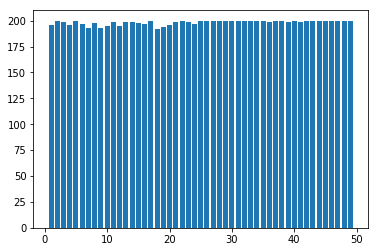

(9728, 960)
[[0.38259048 0.47043366 0.45698015 ... 0.48037052 0.54256064 0.41356523]
 [0.36948615 0.46544824 0.441965   ... 0.47674889 0.54780905 0.40928742]
 [0.35037566 0.46943302 0.44736133 ... 0.47198432 0.57316619 0.38508744]
 ...
 [0.3592604  0.45673127 0.43547185 ... 0.52239648 0.49749173 0.41431011]
 [0.35413113 0.45320654 0.43200286 ... 0.5207825  0.49023103 0.42396991]
 [0.36833887 0.46280751 0.45115063 ... 0.47749518 0.54949879 0.41119773]]


In [168]:
# smote = SMOTE(sampling_strategy='minority')
# x_smote, y_smote = smote.fit_resample(X, y)
# # fit predictor and target variable

# for i in range(8):
#     x_smote, y_smote = smote.fit_resample(x_smote, y_smote)
# Try these below instead --- Jin Hong
#x_smote, y_smote = X_train, y
#x_smote, y_smote = SMOTE().fit_resample(X_train, y)
#x_smote, y_smote = SMOTETomek(random_state=42).fit_resample(X_train, y)
#x_smote, y_smote = SMOTEENN(random_state=42).fit_resample(X_train, y)



# ------------------------ Divider ------------------------------#
# ------------- Manual downsample + SMOTETomek ------------------#

strategy = Counter(y)
for key, val in strategy.items():
    if key < 11:
        strategy[key] = 200
        
    else:
        strategy[key] = val

x_rus, y_rus = RandomUnderSampler(sampling_strategy=strategy).fit_resample(X_train, y)
x_smote, y_smote = SMOTETomek(sampling_strategy='all').fit_resample(x_rus, y_rus)

pyplot.bar(Counter(y_smote).keys(), Counter(y_smote).values())
pyplot.show()

print(x_smote.shape)
print(x_smote)

In [170]:
fp = np.zeros((len(x_smote), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
print(len(x_smote))
for i, row in enumerate(x_smote):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('train_smote_random10_minmax.npy', fp)

9728


In [171]:
labels = []
for i, row in enumerate(y_smote.values):
    labels.append(row)
with open('label_smote_random10_minmax.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [ ]:
fp = np.zeros((len(X_test), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32) #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
for i, row in enumerate(X_test):
    data, label = read_xyz(row)
    fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
np.save('test_minmax.npy', fp)

In [ ]:
labels = []
for i, row in enumerate(X_test_index):
    labels.append(row-1)
with open('label_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [11]:
# fp = np.zeros((len(dtf), NUM_FEATURES, NUM_FRAMES, NUM_JOINTS, 1), dtype=np.float32)
#     #construct a matrix, with num of data, num of features for each joint, num of frames, num of joints, num of people(always 1 in our case)
# with open(FILE_NAME, 'r') as f:
#         csv_reader = reader(f)
#         labels = []
#         for i, row in enumerate(csv_reader):
#             data, label = read_xyz(row)
#             labels.append(int(label))
#             fp[i, :, :, :, 0] = data
#fp = normalisation(fp)
#np.save('train_data.npy', fp)
#np.save('test_data.npy', fp)

# with open('label.pkl', 'wb') as f:
#     pickle.dump(labels, f)

In [164]:
unpickled_df = pd.read_pickle("label_smote_random10.pkl")
unpickled_df[14400:]

[42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42]